In [1]:
#make sure you have data_utils file
#install requirements for mambavision
# a. Get system build deps
!apt-get update && \
 apt-get install -y build-essential cmake libomp-dev

# b. Pre-install ninja (so the wheel build uses it)
!pip install --upgrade ninja

# c. Build & install mamba-ssm against your existing torch/CUDA
!pip install --no-build-isolation mamba-ssm==2.2.4

# d. Now install mambavision
!pip install mambavision==1.1.0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,918 kB]
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Fetched 2,358 kB in 3s (858 kB/

In [2]:
# imports
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize
import torchaudio.transforms as T
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import torchaudio
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from tqdm import tqdm
from transformers import AutoModel, AutoModelForImageClassification
from mambavision import create_model
import argparse
from data_utils import DEAMHandler, WaveDataset
import random
import librosa.display


/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
# -------------------- Dataset --------------------
# Patching original WaveDataset to return regression label and Mel spectrogram
class WaveToVisionWrapper(torch.utils.data.Dataset):
    def __init__(self, wave_dataset, duration=45, sr=16000, img_size=224,
                 valence_mean=0.5, valence_std=1.0, arousal_mean=0.5, arousal_std=1.0):
        self.base_ds = wave_dataset
        self.handler = wave_dataset.h
        self.ids = wave_dataset.ids
        self.duration = duration
        self.sr = sr
        self.max_len = sr * duration
        self.mel = T.MelSpectrogram(sample_rate=sr, n_mels=128)
        self.resize = Resize((img_size, img_size))
        self.valence_mean = valence_mean
        self.valence_std = valence_std
        self.arousal_mean = arousal_mean
        self.arousal_std = arousal_std
    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        sid = self.ids[idx]

        # Load preprocessed chunks from cache
        mel_path = f"/content/mel_cache/{sid}.pt"
         #f"/mel_cache/{sid}.pt"
        if not os.path.exists(mel_path):
            raise FileNotFoundError(f"Missing cached mel: {mel_path}")
        chunks = torch.load(mel_path)  # shape: [num_chunks, 3, 224, 224]

        # Load and normalize label
        row = self.handler.static_annotations[self.handler.static_annotations["song_id"] == sid]
        valence = float(row["valence_mean"].item())
        arousal = float(row["arousal_mean"].item())
        valence = (valence - self.valence_mean) / self.valence_std
        arousal = (arousal - self.arousal_mean) / self.arousal_std

        label = torch.tensor([valence, arousal], dtype=torch.float32)
        labels = torch.stack([label] * len(chunks))  # shape: [num_chunks, 2]

        return chunks, labels, sid



In [4]:
# Downloading DEAM dataset from kagglehub
handler = DEAMHandler()
all_ids = handler.static_annotations["song_id"].tolist()
base_wave_ds = WaveDataset(handler, all_ids)

100%|██████████| 1.83G/1.83G [01:33<00:00, 21.0MB/s]

Extracting files...


Dataset root: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1
Audio directory: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio

Dataset Preview:
   song_id  valence_mean  valence_std  arousal_mean  arousal_std
0        2           3.1         0.94           3.0         0.63
1        3           3.5         1.75           3.3         1.62
2        4           5.7         1.42           5.5         1.63
3        5           4.4         2.01           5.3         1.85
4        7           5.8         1.47           6.4         1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   song_id       1744 non-null   int64  
 1   valence_mean  1744 non-null   float64
 2   valence_std   1744 non-null   float

In [6]:
#create the data files
# Parameters
sr = 16000
duration = 45
max_len = sr * duration
n_mels = 256
n_fft = 2048
hop_length = 512
win_length = 2048

mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_mels=n_mels,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length
)

chunk_size_sec = 5
samples_per_frame = 512
frames_per_sec = sr // samples_per_frame  #  31
chunk_frames = chunk_size_sec * frames_per_sec  # =  155

target_chunks = 6
mel_frames_total = (max_len // samples_per_frame)  # 1406 for 45 sec
hop_frames = (mel_frames_total - chunk_frames) // (target_chunks - 1)

print(f"frames_per_sec={frames_per_sec}, chunk_frames={chunk_frames}, hop_frames={hop_frames}")

os.makedirs("mel_cache", exist_ok=True)

for sid in all_ids:
    path = f"mel_cache/{sid}.pt"
    if os.path.exists(path):
        continue

    wav_np, _ = handler.get_waveform(sid, target_sr=sr, mono=True)
    waveform = torch.tensor(wav_np[:max_len]).unsqueeze(0)  # [1, T]

    mel = mel_tf(waveform).log2().clamp(min=-10).squeeze(0)  # [n_mels, time]

    # Normalize per sample
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)

    chunks = []
    for i in range(target_chunks):
        start = i * hop_frames
        chunk = mel[:, start:start + chunk_frames]
        if chunk.shape[-1] == chunk_frames:
            chunk = chunk.unsqueeze(0).repeat(3, 1, 1)  # [3, n_mels, T]
            chunk = F.interpolate(
                chunk.unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            )
            chunks.append(chunk.squeeze(0))  # [3, 224, 224]

    if chunks:
        chunks_tensor = torch.stack(chunks)  # [target_chunks, 3, 224, 224]
        torch.save(chunks_tensor, path)


frames_per_sec=31, chunk_frames=155, hop_frames=250


# New Section

In [13]:
SEED = 42

# Set all relevant seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#  TEMP: wrap dataset to access song IDs for splitting
full_ds = WaveToVisionWrapper(base_wave_ds)

# Split to train / val / test
train_size = int(0.8 * len(full_ds))
val_size   = int(0.1 * len(full_ds))
test_size  = len(full_ds) - train_size - val_size
train_ds_raw, val_ds_raw, test_ds_raw = torch.utils.data.random_split(
    full_ds,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

#  Compute normalization stats using only train + val
train_val_indices = train_ds_raw.indices + val_ds_raw.indices
train_val_ids = [full_ds.ids[i] for i in train_val_indices]
train_val_rows = handler.static_annotations[handler.static_annotations["song_id"].isin(train_val_ids)]
vals = train_val_rows[["valence_mean", "arousal_mean"]].values
valence_mean, arousal_mean = vals.mean(axis=0)
valence_std, arousal_std = vals.std(axis=0)

print(f"Valence Mean: {valence_mean:.4f}, Std: {valence_std:.4f}")
print(f"Arousal Mean: {arousal_mean:.4f}, Std: {arousal_std:.4f}")

# Re-create dataset with normalization applied
full_ds = WaveToVisionWrapper(
    base_wave_ds,
    valence_mean=valence_mean,
    valence_std=valence_std,
    arousal_mean=arousal_mean,
    arousal_std=arousal_std
)

#  Re-split full_ds using the same indices
train_ds = torch.utils.data.Subset(full_ds, train_ds_raw.indices)
val_ds   = torch.utils.data.Subset(full_ds, val_ds_raw.indices)
test_ds  = torch.utils.data.Subset(full_ds, test_ds_raw.indices)


Valence Mean: 4.9069, Std: 1.1798
Arousal Mean: 4.8196, Std: 1.2882


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [23]:
# == Hyperparameters ==
BATCH_SIZE      = 16
max_LR          = 1e-3
min_LR          = 1e-5
LR              = 1e-4
EPOCHS          = 50
weight_decay    = 1e-4
var_lambda = 0.05
corr_lambda = 0.05
train_augmentations = transforms.Compose([
    transforms.RandomApply([T.TimeMasking(time_mask_param=30)], p=0.5),
    transforms.RandomApply([T.FrequencyMasking(freq_mask_param=15)], p=0.5)
])

In [24]:
class MambaEmotionRegressor(nn.Module):
    def __init__(self, device, pretrained=True, augmentations=None):
        super().__init__()
        self.device = device
        self.backbone = create_model('mamba_vision_S', pretrained=pretrained).to(self.device)
        self.augmentations = augmentations
        self.SpecialAug = None
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224).to(self.device)
            self.backbone.eval()
            feature_vec = self.backbone.forward_features(dummy)
            feature_dim = feature_vec.shape[1]

        # Separate heads for Valence and Arousal
        self.valence_head = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        ).to(self.device)

        self.arousal_head = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        ).to(self.device)


    def forward(self, x, mode='test'):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # [B, 1, 128, T]
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # [B, 3, 128, T]
        if self.augmentations and mode == 'train':
            x = self.augmentations(x)
            if self.SpecialAug:
                x = self.SpecialAug(x)
        features = self.backbone.forward_features(x)
        valence = self.valence_head(features)
        arousal = self.arousal_head(features)

        return torch.cat([valence, arousal], dim=1)


    def freeze_backbone(self):
        #Freeze all backbone parameters (except for regressor and head)
        for param in self.backbone.parameters():
            param.requires_grad = False


In [25]:
def train(model, loader, optimizer,scheduler, device,var_lambda,corr_lambda):
    model.train()
    total_loss = 0
    target_chunks = 6

    # Wrap the DataLoader with tqdm for progress bar
    for x, y, _ in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x, mode='train')
        loss = F.mse_loss(pred, y)

        var_penalty = -torch.var(pred, dim=0).mean()  # negative to encourage spreading
        # Compute correlation between valence and arousal in predicted values
        vx = pred[:, 0] - pred[:, 0].mean()
        vy = pred[:, 1] - pred[:, 1].mean()
        corr = torch.sum(vx * vy) / (torch.norm(vx) * torch.norm(vy) + 1e-8)

        corr_penalty = corr**2  # squared to avoid negative correlation
        loss = loss + var_lambda * var_penalty + corr_lambda * corr_penalty
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # for CyclicLR
        total_loss += loss.item() * x.size(0)
        # print(f"Batch LR: {optimizer.param_groups[0]['lr']:.6f}")

    return (total_loss / len(loader.dataset))/target_chunks

def evaluate(model, loader, device):
    model.eval()

    song_sums = defaultdict(lambda: torch.zeros(2))
    song_counts = defaultdict(int)
    song_targets = {}

    with torch.no_grad():
        for x, y, sids in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            for i in range(len(sids)):
                sid = sids[i]
                song_sums[sid] += pred[i].detach().cpu()
                song_counts[sid] += 1
                song_targets[sid] = y[i].cpu()

    avg_preds, avg_targets = [], []
    for sid in song_sums:
        avg_pred = song_sums[sid] / song_counts[sid]
        avg_preds.append(avg_pred)
        avg_targets.append(song_targets[sid])

    avg_preds = torch.stack(avg_preds)
    avg_targets = torch.stack(avg_targets)
    loss = F.mse_loss(avg_preds, avg_targets)

    return loss.item(), avg_preds, avg_targets


In [18]:
#model initializing

torch.serialization.add_safe_globals([argparse.Namespace])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model & Optimizer
model = MambaEmotionRegressor(device=device, augmentations=train_augmentations)
model.freeze_backbone()  # Freeze the backbone first

# Unfreeze the head and upper levels
for param in model.backbone.head.parameters():
    param.requires_grad = True
for param in model.backbone.levels[-1].parameters():
    param.requires_grad = True
for param in model.backbone.levels[-2].parameters():
    param.requires_grad = True

trainable_params = (
    list(model.backbone.head.parameters()) +
    list(model.valence_head.parameters()) +
    list(model.arousal_head.parameters()) +
    list(model.backbone.levels[-1].parameters())+
    list(model.backbone.levels[-2].parameters())
)

optimizer = torch.optim.AdamW(trainable_params,lr=min_LR,weight_decay=weight_decay)
scheduler = CyclicLR(
    optimizer,
    base_lr=min_LR,
    max_lr=max_LR,
    step_size_up=134,    # Steps to reach max_lr
    mode='triangular2',
    cycle_momentum=False
)

train_losses = []
val_losses = []

100%|██████████| 574M/574M [00:12<00:00, 48.1MB/s]


In [26]:
def collate_chunks_as_batch(batch):
    all_chunks = []
    all_labels = []
    all_ids = []

    for chunks, labels, sid in batch:
        all_chunks.append(chunks)       # [num_chunks, 3, H, W]
        all_labels.append(labels)       # [num_chunks, 2]
        all_ids.extend([sid] * chunks.shape[0])  # one sid per chunk

    return torch.cat(all_chunks), torch.cat(all_labels), all_ids

#Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_chunks_as_batch)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_chunks_as_batch)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_chunks_as_batch)


In [27]:
# Train
best_val_loss = float('inf')  # initialize

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer,scheduler,device,var_lambda,corr_lambda)
    val_loss, _, _ = evaluate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # Save model weights
        print(f"Saved new best model at epoch {epoch}")

    #scheduler.step(val_loss)
    for i, param_group in enumerate(optimizer.param_groups):
      print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {param_group['lr']:.6f}")

Saved new best model at epoch 1
Epoch 01 | Train Loss: 0.7159 | Val Loss: 0.5871 | LR: 0.000660


Epoch 02 | Train Loss: 0.5884 | Val Loss: 0.6010 | LR: 0.000690


Saved new best model at epoch 3
Epoch 03 | Train Loss: 0.5159 | Val Loss: 0.4119 | LR: 0.000040


Epoch 04 | Train Loss: 0.4545 | Val Loss: 0.4313 | LR: 0.000320


Saved new best model at epoch 5
Epoch 05 | Train Loss: 0.4636 | Val Loss: 0.4043 | LR: 0.000365


Saved new best model at epoch 6
Epoch 06 | Train Loss: 0.4171 | Val Loss: 0.3947 | LR: 0.000040


Epoch 07 | Train Loss: 0.3832 | Val Loss: 0.4219 | LR: 0.000158


Epoch 08 | Train Loss: 0.3794 | Val Loss: 0.4088 | LR: 0.000195


Saved new best model at epoch 9
Epoch 09 | Train Loss: 0.3368 | Val Loss: 0.3704 | LR: 0.000032


Saved new best model at epoch 10
Epoch 10 | Train Loss: 0.2799 | Val Loss: 0.3671 | LR: 0.000080


Epoch 11 | Train Loss: 0.2822 | Val Loss: 0.3847 | LR: 0.000106


Saved new best model at epoch 12
Epoch 12 | Train Loss: 0.2489 | Val Loss: 0.3667 | LR: 0.000025


Epoch 13 | Train Loss: 0.2192 | Val Loss: 0.3791 | LR: 0.000043


Epoch 14 | Train Loss: 0.2168 | Val Loss: 0.3765 | LR: 0.000060


Epoch 15 | Train Loss: 0.1933 | Val Loss: 0.3842 | LR: 0.000019


Epoch 16 | Train Loss: 0.1836 | Val Loss: 0.3688 | LR: 0.000026


Epoch 17 | Train Loss: 0.1928 | Val Loss: 0.3779 | LR: 0.000036


Saved new best model at epoch 18
Epoch 18 | Train Loss: 0.1710 | Val Loss: 0.3622 | LR: 0.000016


Epoch 19 | Train Loss: 0.1717 | Val Loss: 0.3672 | LR: 0.000017


Epoch 20 | Train Loss: 0.1632 | Val Loss: 0.3634 | LR: 0.000023


Epoch 21 | Train Loss: 0.1568 | Val Loss: 0.3768 | LR: 0.000013


Epoch 22 | Train Loss: 0.1651 | Val Loss: 0.3679 | LR: 0.000013


Epoch 23 | Train Loss: 0.1689 | Val Loss: 0.3625 | LR: 0.000017


Saved new best model at epoch 24
Epoch 24 | Train Loss: 0.1549 | Val Loss: 0.3602 | LR: 0.000012


Epoch 25 | Train Loss: 0.1569 | Val Loss: 0.3668 | LR: 0.000012


Epoch 26 | Train Loss: 0.1503 | Val Loss: 0.3616 | LR: 0.000014


Saved new best model at epoch 27
Epoch 27 | Train Loss: 0.1579 | Val Loss: 0.3567 | LR: 0.000011


Epoch 28 | Train Loss: 0.1380 | Val Loss: 0.3616 | LR: 0.000011


Epoch 29 | Train Loss: 0.1438 | Val Loss: 0.3621 | LR: 0.000012


Epoch 30 | Train Loss: 0.1437 | Val Loss: 0.3652 | LR: 0.000011


Epoch 31 | Train Loss: 0.1421 | Val Loss: 0.3665 | LR: 0.000010


Epoch 32 | Train Loss: 0.1455 | Val Loss: 0.3822 | LR: 0.000011


Epoch 33 | Train Loss: 0.1334 | Val Loss: 0.3745 | LR: 0.000010


Epoch 34 | Train Loss: 0.1393 | Val Loss: 0.3621 | LR: 0.000010


Epoch 35 | Train Loss: 0.1365 | Val Loss: 0.3650 | LR: 0.000010


Epoch 36 | Train Loss: 0.1188 | Val Loss: 0.3717 | LR: 0.000010


Epoch 37 | Train Loss: 0.1331 | Val Loss: 0.3632 | LR: 0.000010


Epoch 38 | Train Loss: 0.1238 | Val Loss: 0.3711 | LR: 0.000010


Epoch 39 | Train Loss: 0.1206 | Val Loss: 0.3588 | LR: 0.000010


Epoch 40 | Train Loss: 0.1312 | Val Loss: 0.3673 | LR: 0.000010


Epoch 41 | Train Loss: 0.1247 | Val Loss: 0.3591 | LR: 0.000010


Epoch 42 | Train Loss: 0.1252 | Val Loss: 0.3811 | LR: 0.000010


Epoch 43 | Train Loss: 0.1250 | Val Loss: 0.3678 | LR: 0.000010


Epoch 44 | Train Loss: 0.1236 | Val Loss: 0.3670 | LR: 0.000010


Epoch 45 | Train Loss: 0.1158 | Val Loss: 0.3725 | LR: 0.000010


Epoch 46 | Train Loss: 0.1125 | Val Loss: 0.3625 | LR: 0.000010


Epoch 47 | Train Loss: 0.1133 | Val Loss: 0.3630 | LR: 0.000010


Epoch 48 | Train Loss: 0.1135 | Val Loss: 0.3661 | LR: 0.000010


Epoch 49 | Train Loss: 0.1108 | Val Loss: 0.3770 | LR: 0.000010


Epoch 50 | Train Loss: 0.1087 | Val Loss: 0.3646 | LR: 0.000010


In [28]:
# Load best model - the one with the lowest val error
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # eval mode for inference

MambaEmotionRegressor(
  (backbone): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(96, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         


 Final Test Loss (MSE): 0.4196
Valence MSE (unnormlized): 0.6211
Arousal MSE (unnormlized): 0.6523


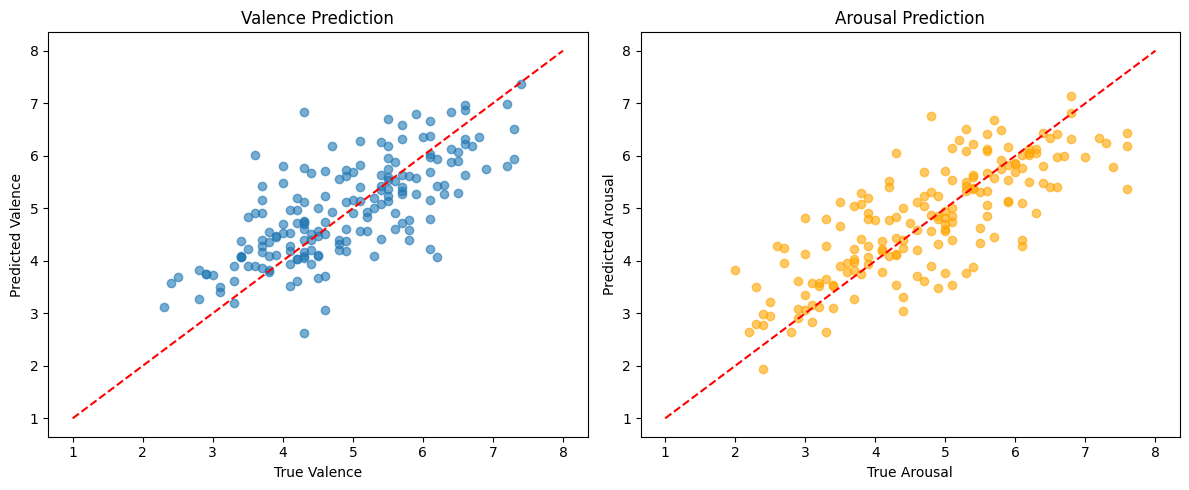

In [29]:
#  Test & Analysis
test_loss, preds, targets = evaluate(model, test_loader, device)
print(f"\n Final Test Loss (MSE): {test_loss:.4f}")

# Plot prediction vs. true for valence and arousal
valence_pred = (preds[:, 0].numpy())*valence_std + valence_mean
valence_true = (targets[:, 0].numpy())*valence_std + valence_mean
arousal_pred = (preds[:, 1].numpy())*arousal_std + arousal_mean
arousal_true = (targets[:, 1].numpy())*arousal_std + arousal_mean

valence_mse = mean_squared_error(valence_true, valence_pred)
arousal_mse = mean_squared_error(arousal_true, arousal_pred)

print(f"Valence MSE (unnormlized): {valence_mse:.4f}")
print(f"Arousal MSE (unnormlized): {arousal_mse:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(valence_true, valence_pred, alpha=0.6)
plt.plot([1, 8], [1, 8], 'r--', label='y = x')

plt.xlabel("True Valence"); plt.ylabel("Predicted Valence")
plt.title("Valence Prediction")

plt.subplot(1, 2, 2)
plt.scatter(arousal_true, arousal_pred, alpha=0.6, color='orange')
plt.plot([1, 8], [1, 8], 'r--', label='y = x')


plt.xlabel("True Arousal"); plt.ylabel("Predicted Arousal")
plt.title("Arousal Prediction")


plt.tight_layout()
plt.show()

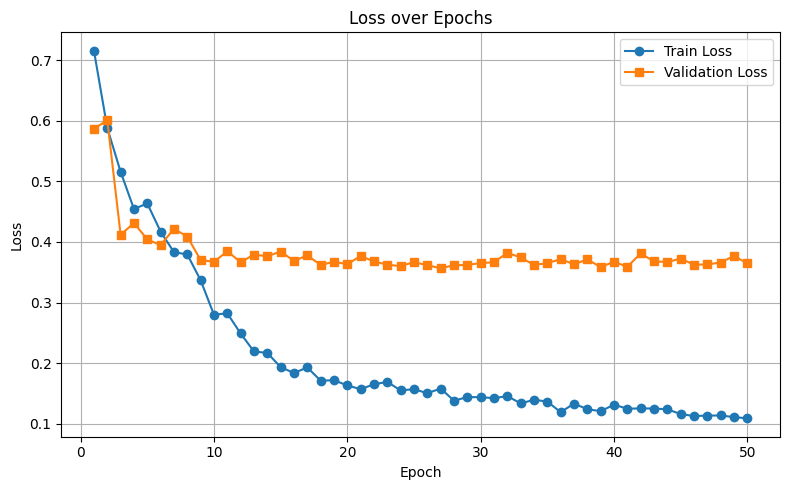

In [30]:
epochs = list(range(1, len(train_losses) + 1))
train_losses_normalized = [x for x in train_losses]
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_normalized, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

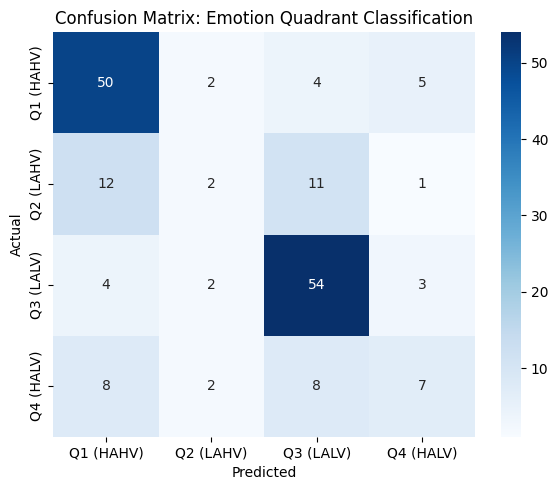

In [31]:
#Confusion matrix
# Denormalized valence/arousal arrays
valence_pred = preds[:, 0].numpy() * valence_std + valence_mean
valence_true = targets[:, 0].numpy() * valence_std + valence_mean
arousal_pred = preds[:, 1].numpy() * arousal_std + arousal_mean
arousal_true = targets[:, 1].numpy() * arousal_std + arousal_mean

# quadrant assignment function
def get_quadrant(v, a, threshold=4.9):
    if v >= threshold and a >= threshold:
        return 0  # Q1: High Valence, High Arousal (HAVH)
    elif v < threshold and a >= threshold:
        return 1  # Q2: Low Valence, High Arousal (LAVH)
    elif v < threshold and a < threshold:
        return 2  # Q3: Low Valence, Low Arousal (LALV)
    else:
        return 3  # Q4: High Valence, Low Arousal (HALV)
true_quads = [get_quadrant(v, a) for v, a in zip(valence_true, arousal_true)]
pred_quads = [get_quadrant(v, a) for v, a in zip(valence_pred, arousal_pred)]

# Compute confusion matrix
cm = confusion_matrix(true_quads, pred_quads)

# Plot
labels = ['Q1 (HAHV)', 'Q2 (LAHV)', 'Q3 (LALV)', 'Q4 (HALV)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Emotion Quadrant Classification")
plt.tight_layout()
plt.show()


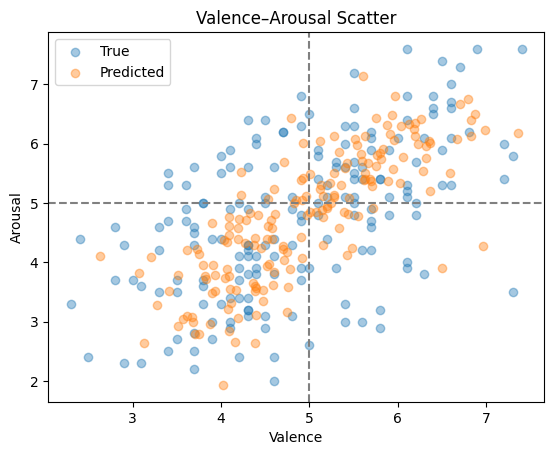

In [32]:
#scatterplot of predicted and true V/A values
plt.scatter(valence_true, arousal_true, alpha=0.4, label='True')
plt.scatter(valence_pred, arousal_pred, alpha=0.4, label='Predicted')
plt.axhline(5.0, color='gray', linestyle='--')
plt.axvline(5.0, color='gray', linestyle='--')
plt.legend()
plt.title("Valence–Arousal Scatter")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.show()

In [44]:
# particular song result example:

song_index = 10
# Denormalize predictions and targets
valence_pred = preds[:, 0].numpy() * valence_std + valence_mean
valence_true = targets[:, 0].numpy() * valence_std + valence_mean
arousal_pred = preds[:, 1].numpy() * arousal_std + arousal_mean
arousal_true = targets[:, 1].numpy() * arousal_std + arousal_mean

# Print the specific song's result
print(f"--- Song {song_index} ---")
print(f"Predicted Valence: {valence_pred[song_index]:.4f} | Target: {valence_true[song_index]:.4f}")
print(f"Predicted Arousal: {arousal_pred[song_index]:.4f} | Target: {arousal_true[song_index]:.4f}")


--- Song 10 ---
Predicted Valence: 4.5751 | Target: 4.5000
Predicted Arousal: 4.5761 | Target: 5.0000


In [45]:
#correlation comparison
# Ground truth correlation
true_corr = np.corrcoef(valence_true, arousal_true)[0, 1]

# Predicted correlation
pred_corr = np.corrcoef(valence_pred, arousal_pred)[0, 1]

# Difference in correlation
corr_diff = abs(true_corr - pred_corr)

print(f"True correlation:     {true_corr:.4f}")
print(f"Predicted correlation: {pred_corr:.4f}")
print(f"Difference:            {corr_diff:.4f}")

True correlation:     0.5453
Predicted correlation: 0.7805
Difference:            0.2352


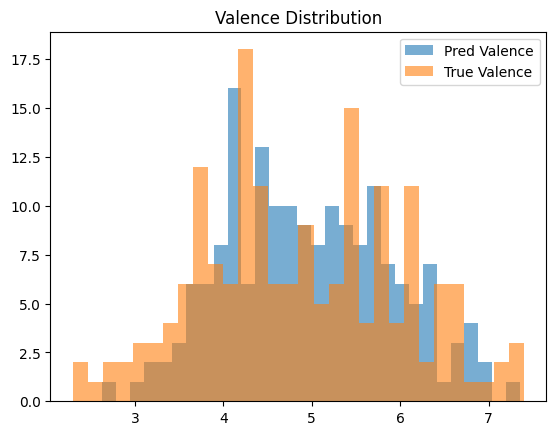

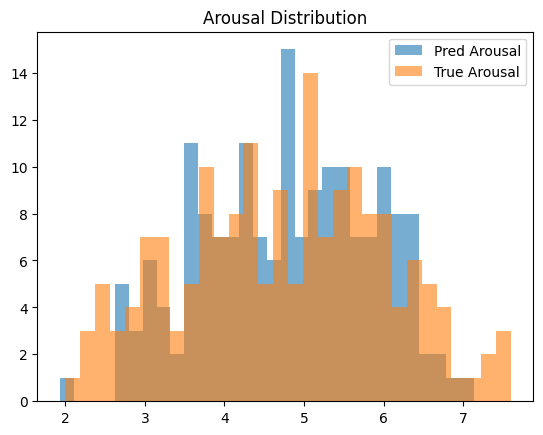

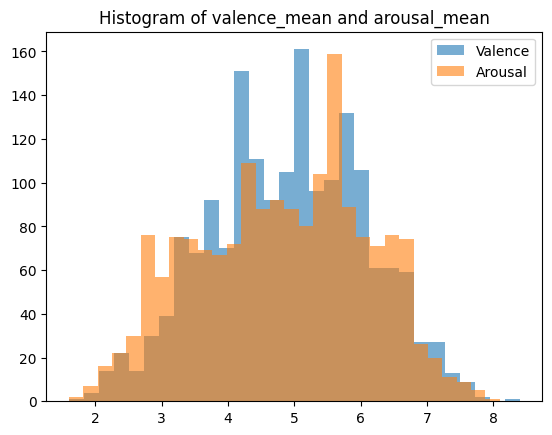

In [35]:
#valence and arousal histograms analysis
plt.hist(valence_pred, bins=30, alpha=0.6, label="Pred Valence")
plt.hist(valence_true, bins=30, alpha=0.6, label="True Valence")
plt.legend(); plt.title("Valence Distribution"); plt.show()

plt.hist(arousal_pred, bins=30, alpha=0.6, label="Pred Arousal")
plt.hist(arousal_true, bins=30, alpha=0.6, label="True Arousal")
plt.legend(); plt.title("Arousal Distribution"); plt.show()

vals = handler.static_annotations[["valence_mean", "arousal_mean"]].values
plt.hist(vals[:, 0], bins=30, alpha=0.6, label='Valence')
plt.hist(vals[:, 1], bins=30, alpha=0.6, label='Arousal')
plt.title("Histogram of valence_mean and arousal_mean")
plt.legend()
plt.show()


In [ ]:
# #mel saving
# !mkdir -p /content/drive/MyDrive/mel_cache
# !mv mel_cache/*.pt /content/drive/MyDrive/mel_cache/

mv: cannot stat 'mel_cache/*.pt': No such file or directory


In [ ]:
# Check trainable parameters
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {num_trainable:,}")